In [4]:
import sys

sys.path.append("../..")
import os

if not os.path.exists('figures'):
    os.makedirs('figures')


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.data.STAR.star import STARDataset
from notebooks.plot_utils import set_default_matplotlib_settings

set_default_matplotlib_settings()

In [5]:
dgp = STARDataset("../../src/data/STAR/STAR_Students.csv")

X_train, S_train, A_train, Y_train, X_eval, gt_adjusted_ite_eval = dgp.sample(
    1000, 1000, rct_fraction_of_rural=0.5, eval_fraction_of_rct=0.2)

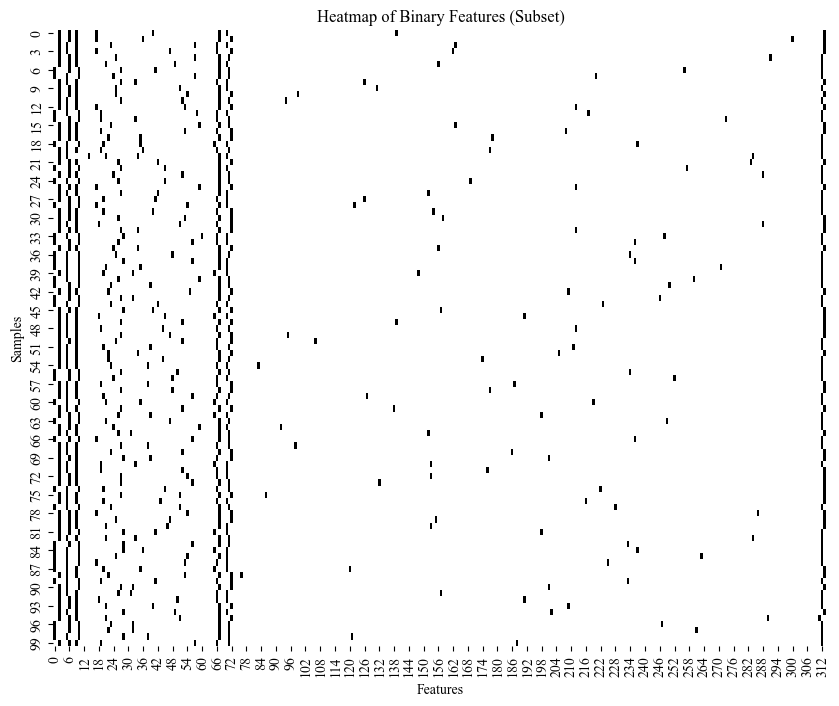

In [6]:


# Visualize a subset of the data for better readability
subset = X_train[:100, :]  # Adjust the slice as needed for visualization

plt.figure(figsize=(10, 8))
sns.heatmap(subset, cmap="binary", cbar=False)
plt.title("Heatmap of Binary Features (Subset)")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()


In [7]:
print('Fraction of trial participants', np.mean(S_train))

Fraction of trial participants 0.5


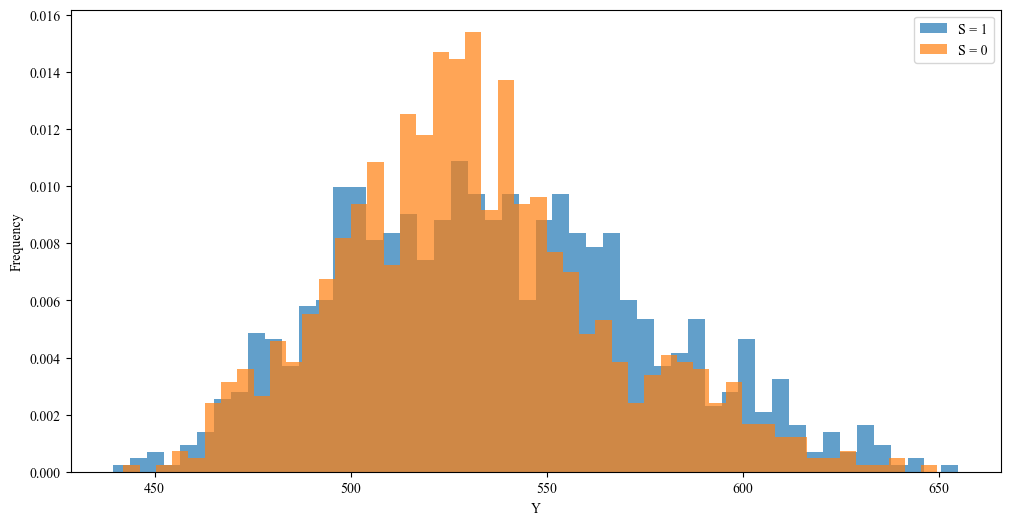

Mean ITE 5.757652707613404
Std ITE 79.67724276590207


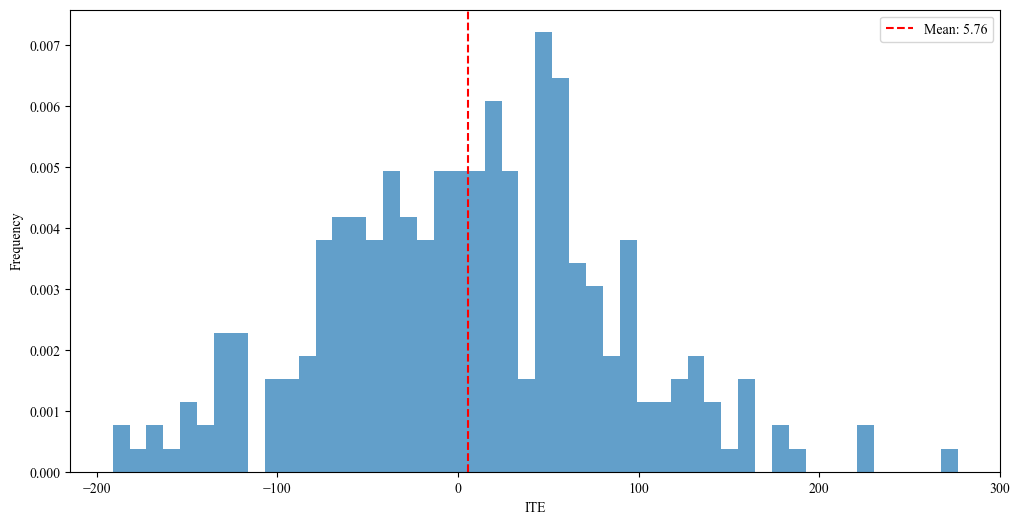

In [8]:
plt.figure(figsize=(12, 6))

# Histogram for S_train == 1
plt.hist(Y_train[S_train.flatten() == 1], bins=50, alpha=0.7, label='S = 1', density=True)

# Histogram for S_train == 0
plt.hist(Y_train[S_train.flatten() == 0], bins=50, alpha=0.7, label='S = 0', density=True)

plt.xlabel('Y')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot histograms for gt_adjusted_ite_eval
plt.figure(figsize=(12, 6))

# Histogram for positive values
plt.hist(gt_adjusted_ite_eval, bins=50, alpha=0.7, density=True)

# Calculate the mean of gt_adjusted_ite_eval
mean_ite = np.mean(gt_adjusted_ite_eval)
std_ite = np.std(gt_adjusted_ite_eval)
print('Mean ITE', mean_ite)
print('Std ITE', std_ite)

# Plot a vertical line at the mean
plt.axvline(mean_ite, color='red', linestyle='--', label=f'Mean: {mean_ite:.2f}')

plt.xlabel('ITE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [9]:
# Compute ATE from trial
Y_treated = np.mean(Y_train[(S_train==1) & (A_train==1)])
Y_control = np.mean(Y_train[(S_train==1) & (A_train==0)])
ate = Y_treated - Y_control
print("ATE", ate)

print(gt_adjusted_ite_eval.shape)

# Compute RMSE for error ite-ate
rmse = np.sqrt(np.mean((gt_adjusted_ite_eval - ate) ** 2))
print("RMSE for error (ITE - ATE):", rmse)

ATE 11.76064883758147
(281,)
RMSE for error (ITE - ATE): 79.90305987453112


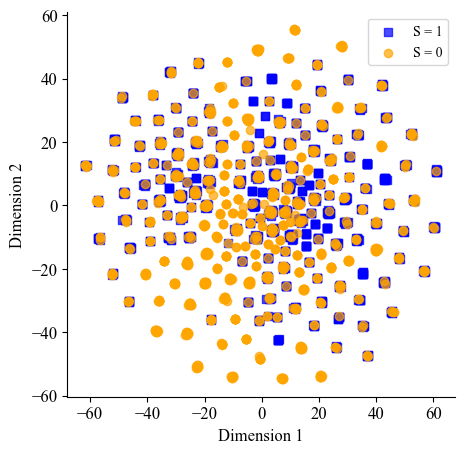

In [10]:
# Check whether features overlap for S=1 and S=0 using PCA dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train) # for mean-centering
reducer = TSNE(n_components=2)
X_reduced = reducer.fit_transform(scaled_X_train)

# Plot scatter plot of X_pca, color by S
plt.figure(figsize=(5, 5))
plt.scatter(X_reduced[S_train.flatten() == 1, 0], X_reduced[S_train.flatten() == 1, 1], alpha=0.7, label='S = 1', c='blue', marker='s')
plt.scatter(X_reduced[S_train.flatten() == 0, 0], X_reduced[S_train.flatten() == 0, 1], alpha=0.7, label='S = 0', c='orange')
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)

plt.legend()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Increase font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('figures/tsne.pdf', bbox_inches='tight')



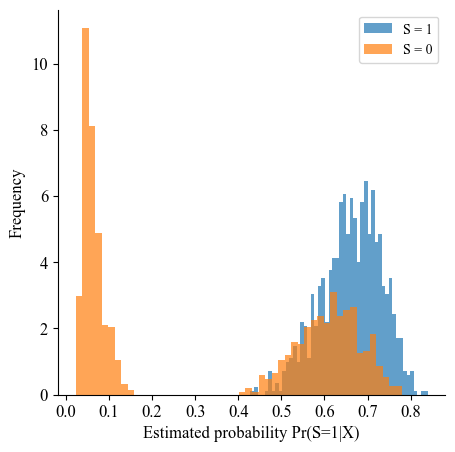

<Figure size 1200x600 with 0 Axes>

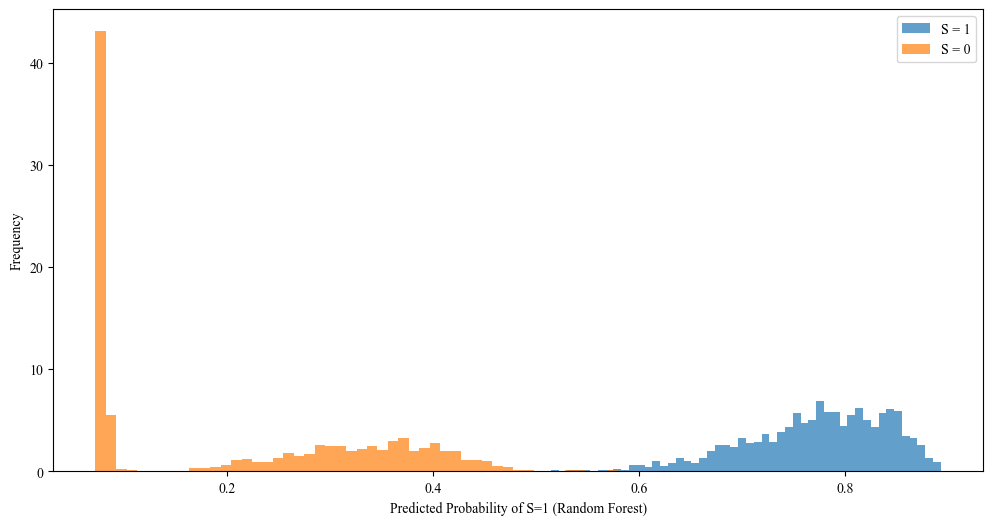

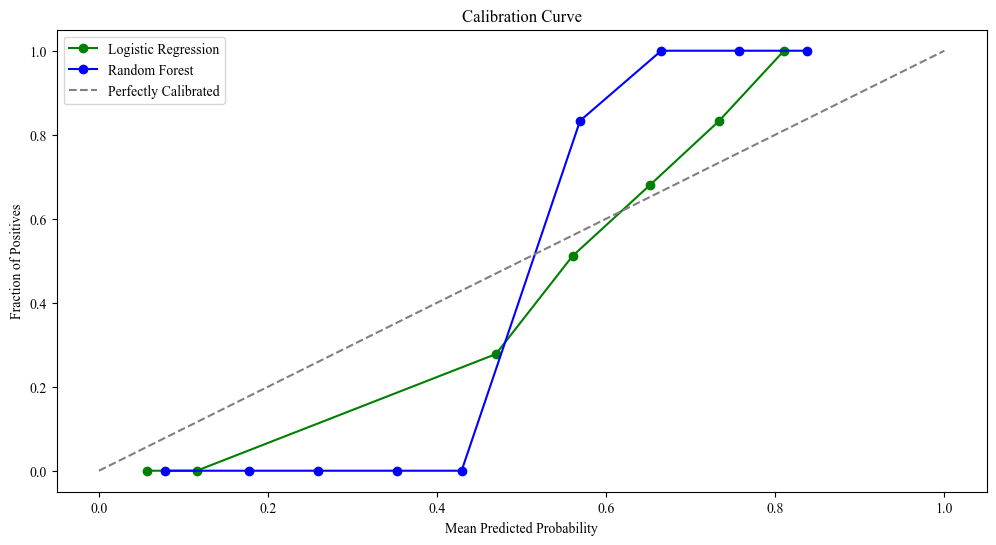

In [11]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve

# Fit cross-validated logistic regression model
log_reg_cv = LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],cv=3, max_iter=1000)
log_reg_cv.fit(X_train, S_train.flatten())

# Predict probabilities
proba = log_reg_cv.predict_proba(X_train)[:, 1]

# Plot histograms
plt.figure(figsize=(5, 5))
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Histogram for S_train == 1
plt.hist(proba[S_train.flatten() == 1], bins=50, alpha=0.7, label='S = 1', density=True)

# Histogram for S_train == 0
plt.hist(proba[S_train.flatten() == 0], bins=50, alpha=0.7, label='S = 0', density=True)

plt.xlabel('Estimated probability Pr(S=1|X)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('figures/propensity_score_hist.pdf', bbox_inches='tight')

# Fit a calibrated random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
calibrated_rf = CalibratedClassifierCV(rf, cv=3)
calibrated_rf.fit(X_train, S_train.flatten())

# Predict probabilities
proba_rf = calibrated_rf.predict_proba(X_train)[:, 1]

# Plot calibration curve

plt.figure(figsize=(12, 6))

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for S_train == 1
plt.hist(proba_rf[S_train.flatten() == 1], bins=50, alpha=0.7, label='S = 1', density=True)

# Histogram for S_train == 0
plt.hist(proba_rf[S_train.flatten() == 0], bins=50, alpha=0.7, label='S = 0', density=True)

plt.xlabel('Predicted Probability of S=1 (Random Forest)')
plt.ylabel('Frequency')
plt.legend()
#plt.title('Histograms of Predicted Probabilities for S=1 (Random Forest)')
plt.show()


# Calibration curve for Logistic Regression
prob_true_log, prob_pred_log = calibration_curve(S_train.flatten(), proba, n_bins=10)

plt.figure(figsize=(12, 6))

# Plot calibration curve for Logistic Regression
plt.plot(prob_pred_log, prob_true_log, marker='o', label='Logistic Regression', color='green')

# Calibration curve for Random Forest
prob_true_rf, prob_pred_rf = calibration_curve(S_train.flatten(), proba_rf, n_bins=10)

# Plot calibration curve for Random Forest
plt.plot(prob_pred_rf, prob_true_rf, marker='o', label='Random Forest', color='blue')

# Add diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()